##### <font color='red'>O código está sendo executado sobre um dataset chamado "clicks.csv" com as seguintes variaveis, cliente, artigo visualizado e quantidade de visualização sobre aquele artigo. Tentarei utilizar dois modelos para recomendar os possíveis artigos, o primeiro sendo os produtos mais poputares e o segundo tentando identificar perfis de clientes que consumiram artigos similares  </font>

##### Carregando alguns dos pacotes que serão utilizado

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sea
sea.set(style="white",color_codes=True)
import operator
import warnings

##### Carregando o dataframe clicks.csv e realizando uma analise exploratoria

In [4]:
data = pd.read_csv('/home/jovyan/work/service/src/raw/clicks.csv')
data.head()

,user_id,user_name,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup
0,0,Alice,15068254230001,1506825423000,2,157541,1506826828020,4,3
1,0,Alice,15068254230001,1506825423000,2,68866,1506826858020,4,3
2,1,Miguel,15068254260002,1506825426000,2,235840,1506827017951,4,1
3,1,Miguel,15068254260002,1506825426000,2,96663,1506827047951,4,1
4,2,Sophia,15068254350003,1506825435000,2,119592,1506827090575,4,1


In [5]:
data.shape

(98, 9)

In [7]:
produto=data['click_article_id'].value_counts()
print("Total Resultados : {}".format(data.shape[0]))
print("Total Click Artigos : {}".format(len(produto)))

Total Resultados : 98
Total Click Artigos : 57


#### Verificando os artigos mais populares 

In [8]:
df_produto_visualizado = data.groupby('click_article_id')['click_environment'].sum().sort_values(ascending=False).reset_index()

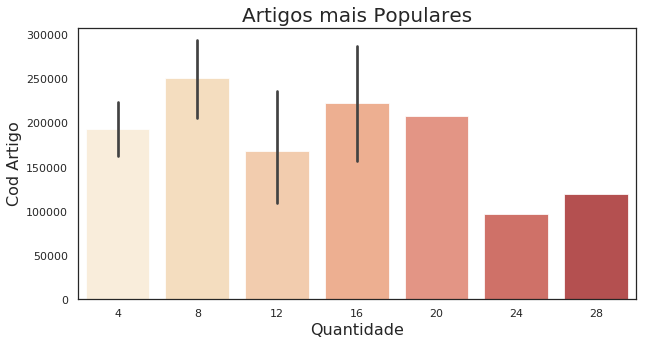

In [9]:
cliente=df_produto_visualizado.head(5)
plt.figure(figsize=(10,5))
sea.barplot(y=df_produto_visualizado.click_article_id, x=df_produto_visualizado.click_environment,palette='OrRd', alpha=.75)
plt.title("Artigos mais Populares", fontsize=20)
plt.xlabel("Quantidade", fontsize=16)
plt.ylabel("Cod Artigo", fontsize=16)
plt.show();

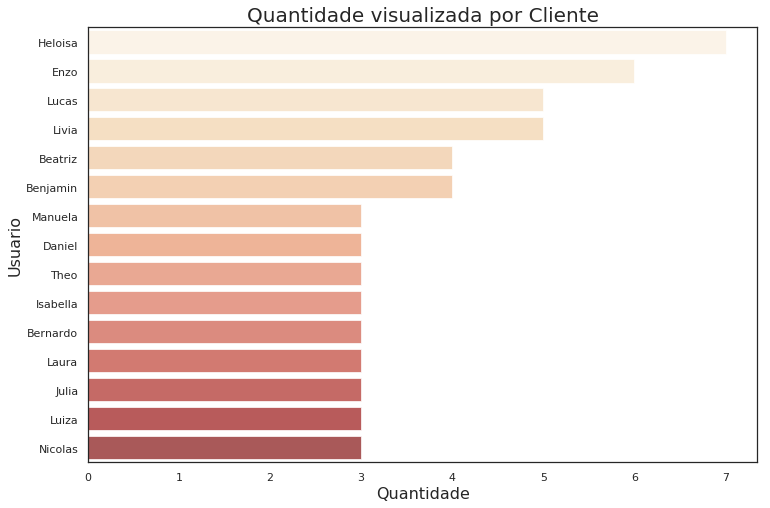

In [10]:
cliente=data['user_name'].value_counts().head(15)
plt.figure(figsize=(12,8))
sea.barplot(y=cliente.index, x=cliente.values,palette='OrRd', alpha=.70)
plt.title("Quantidade visualizada por Cliente", fontsize=20)
plt.xlabel("Quantidade", fontsize=16)
plt.ylabel("Usuario", fontsize=16)
plt.show();

#### Verificando os links mais populares 

In [191]:
df_produto_mais_popular = data.groupby('click_article_id')['user_id'].count().sort_values(ascending=False).reset_index()

In [192]:
clientes = data.user_name
clientes = pd.DataFrame(sorted(set(clientes)))
print(clientes.shape)
clientes.columns = ["nome"]
clientes.head(5)

(35, 1)


,nome
0,Alice
1,Arthur
2,Beatriz
3,Benjamin
4,Bernardo


#### Para recomendar os produtos mais populares poderiamos apenas selecionar os 15 primeiros da analise anterior e indicar para cada cliente, mas abaixo segue a formula para a recomendação.

In [195]:
class RecomendacaoPopularidade(object):
    
    PRODUTO_NAME = 'Popular'
    
    def __init__(self, df_popular):
        self.df_popular = df_popular
        
    def get_model_name(self):
        return self.PRODUTO_NAME
        
    def recomendacao_produtos(self, produtos_to_ignore=[], produtos_to_rec=[], topn=15):
       
        if len(produtos_to_rec) == 0:
            df_recommendations = self.df_popular[~self.df_popular['click_article_id'].isin(produtos_to_ignore)] \
                                 .sort_values('user_id', ascending = False) \
                                 .head(topn)
        else:
            df_recommendations = self.df_popular[self.df_popular['click_article_id'].isin(produtos_to_rec)] \
                                 .sort_values('user_id', ascending = False) \
                                 .head(topn)

        return df_recommendations

In [196]:
popular_modelo = RecomendacaoPopularidade(df_produto_mais_popular)
pop_recommand = popular_modelo.recomendacao_produtos()

nome = []
produtos_recomendados = []
tabela = [nome, produtos_recomendados]
for i in clientes.nome:
    
    for j in pop_recommand.click_article_id:
        nome.append(i)
        produtos_recomendados.append(j)

In [205]:
tabela = pd.DataFrame(tabela)
tabela = tabela.transpose()
tabela.columns = ["user_name",'recommended site']
tabela.head()

,user_name,recommended site
0,Alice,119592
1,Alice,96663
2,Alice,207122
3,Alice,168868
4,Alice,288431


In [206]:
tabela.shape

(525, 2)

In [207]:
tabela.head(5)

,user_name,recommended site
0,Alice,119592
1,Alice,96663
2,Alice,207122
3,Alice,168868
4,Alice,288431


In [208]:
tabela.to_csv('/home/jovyan/work/service/src/processed/artigos_recomendados_por_popularidade.csv', sep='|', encoding='utf-8')

 ###### Agora vamos fazer um outro tipo de recomendação por similaridade

In [210]:
data = data.drop_duplicates(subset=['user_id', 'click_article_id'])

In [211]:
# Criar uma tabela onde os clientes serão as linhas e os produtos serão as colunas
df_clientes_produtos = data.reset_index().pivot(index='user_name', columns='click_article_id', values='click_environment').fillna(0)

In [212]:
df_clientes_produtos.shape

(35, 57)

In [213]:
df_clientes_produtos.head()

click_article_id,2137,4658,30970,44488,48915,61599,68866,69341,96663,97600,...,286417,286420,286421,287174,288431,313504,331966,332114,338351,348103
user_name,,,,,,,,,,,,,,,,,,,,,
Alice,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arthur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Beatriz,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Benjamin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
Bernardo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
# Transformando o dataframe em matrix
df_clientes_produtos_matrix = df_clientes_produtos.values

# Atribuindo o index ao clientes_ids
clientes_ids = df_clientes_produtos.index.tolist()

# Print das 05 primeiras linhas da matrix
df_clientes_produtos_matrix[:5]

array([[0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
        4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

In [216]:
from scipy.sparse.linalg import svds

In [217]:
# Executa a fatoração da matrix
# k = 6, que é o número de fatores que vamos obter
U, sigma, Vt = svds(df_clientes_produtos_matrix, k = 6)
sigma = np.diag(sigma)

# Reconstruindo a matrix 
todos_clientes_preditos = np.dot(np.dot(U, sigma), Vt) 

#Convertendo a matrix reconstruida em DataFrame
df_cf_preds = pd.DataFrame(todos_clientes_preditos, 
                           columns = df_clientes_produtos.columns, 
                           index=clientes_ids).transpose()
df_cf_preds.head()

,Alice,Arthur,Beatriz,Benjamin,Bernardo,Daniel,Davi,Emanuelly,Enzo,Gabriel,...,Maria Luiza,Matheus,Miguel,Murilo,Nicolas,Pedro,Sarah,Sophia,Theo,Valentina
click_article_id,,,,,,,,,,,,,,,,,,,,,
2137,9.737476e-17,4.030673e-17,8.353172e-02,1.042506e-01,-1.377361e-01,-4.017249e-02,-1.090645e-16,1.523492e-01,7.979905e-02,1.895352e-16,...,3.201511e-02,-3.403218e-16,-1.271331e-01,-8.122449e-02,5.194767e-03,1.356363e-01,3.930231e-01,9.849569e-02,6.077295e-17,5.093917e-01
4658,1.808882e-16,5.853683e-17,1.423814e-01,-1.499936e-01,4.292055e-01,4.760718e-02,-1.390249e-16,-1.005322e-01,4.886976e-01,3.216736e-17,...,4.020906e-01,1.017847e-16,-1.371618e-01,-6.872631e-03,8.816457e-01,5.842028e-01,-2.365442e-01,5.453337e-01,7.986305e-17,-1.664265e-01
30970,1.069707e-16,5.100169e-17,2.106964e-01,-7.232536e-02,7.651771e-02,1.273320e-02,-1.397200e-16,-1.111584e-01,-2.843205e-01,6.735558e-17,...,4.600788e-01,-4.471998e-17,-1.831790e-01,-4.156679e-02,5.453337e-01,5.835868e-01,-9.720490e-02,5.108274e-01,8.787222e-17,-3.554246e-02
44488,-1.886384e-31,-5.544986e-32,-6.448026e-17,5.172201e-17,-6.425246e-17,-8.101914e-18,1.355742e-31,1.252092e-16,6.695428e-18,-9.530039e-32,...,5.205359e-17,1.269489e-32,2.498160e-16,3.209648e-17,-2.014246e-16,-1.812084e-16,9.449955e-17,-1.611879e-16,-8.014169e-32,-3.100795e-17
48915,-1.886384e-31,-5.544986e-32,-6.448026e-17,5.172201e-17,-6.425246e-17,-8.101914e-18,1.355742e-31,1.252092e-16,6.695428e-18,-9.530039e-32,...,5.205359e-17,1.269489e-32,2.498160e-16,3.209648e-17,-2.014246e-16,-1.812084e-16,9.449955e-17,-1.611879e-16,-8.014169e-32,-3.100795e-17


In [218]:
class CFRecomendador:
    
    MODEL_NAME = 'Filtro Colaborativo'
    
    def __init__(self, produto_modelo, df_cf_predicoes):
        self.produto_modelo = produto_modelo
        self.df_cf_predicoes = df_cf_predicoes
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recomendacao_produtos(self, cliente_id, produtos_to_ignore=[], produtos_to_rec=[], topn=15):
        if cliente_id in df_cf_preds.columns:
            
            clientes_predicoes = self.df_cf_predicoes[cliente_id].reset_index().rename(columns={cliente_id: 'quantidade'})

            if len(produtos_to_rec) == 0:
                
                df_recommendations = clientes_predicoes[~clientes_predicoes['click_article_id'].isin(produtos_to_ignore)] \
                                     .sort_values('quantidade', ascending = False) \
                                     .head(topn)
            else:
                df_recommendations = clientes_predicoes[clientes_predicoes['click_article_id'].isin(produtos_to_rec)] \
                                     .sort_values('quantidade', ascending = False) \
                                     .head(topn)                
        else:
            df_recommendations = self.popularity_model.recommend_projects(produtos_to_ignore, produtos_to_rec, topn)
            
        return df_recommendations

In [219]:
cfr_model = CFRecomendador(popular_modelo, df_cf_preds)

In [222]:
cliente_id = 'Lucas'

In [223]:
cfr_recommend = cfr_model.recomendacao_produtos(cliente_id)
cfr_recommend.head(5)

,click_article_id,quantidade
12,119592,4.149564
8,96663,4.077844
24,168868,3.323434
38,270225,1.650169
16,145166,1.030820


In [226]:
nome2 = []
produtos2_recomendados = []
tabela2 = [nome2, produtos2_recomendados]
for i in data.user_name:
    cfr_recommend = cfr_model.recomendacao_produtos(i)
    for j in cfr_recommend.click_article_id:
        nome2.append(i)
        produtos2_recomendados.append(j)

In [227]:
tabela2 = pd.DataFrame(tabela2)
tabela2 = tabela2.transpose()
tabela2.columns = ["user_name",'recommended site']
tabela

,user_name,recommended site
0,Alice,119592
1,Alice,96663
2,Alice,207122
3,Alice,168868
4,Alice,288431
5,Alice,145166
6,Alice,284847
7,Alice,235840
8,Alice,108854
9,Alice,159359


In [228]:
tabela2.to_csv('/home/jovyan/work/service/src/processed/artigo_recomendados_por_similaridade.csv', sep='|', encoding='utf-8')